# Application of Cross-Validation in GPFA Inferrence
## By Tiancheng Xu

### Seeing the probelm of the loop aiming to test each hyperparameters, I create this Jupyter Notebook in order to overcome the preblem. However, it is still a temporal method and eventually we need to solve the problem in the Python code.

In [37]:
import numpy as np
import torch
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import sys
from pp import PointProcessGPFA
from base import BaseGP, CosineKernel, enforce_type

## Preparing the spike train

In [14]:
W = np.array([[-1.01038047e-7, 3.91755635e-1, -2.00601176e-7], [-1.18291113e-7, 3.93738773e-1, -2.05185896e-7], [-1.21354510e-7, 3.84734116e-1, -2.3405887e-7], [-9.20452121e-8, 3.87025115e-1, -2.11742197e-7]])
sigma = [3.58804129, 2.29182921, 3.44943223]
mu = [2.50000134, 1.98118901e-2, 2.49998292]
T = 100

In [15]:
base_models = [BaseGP(CosineKernel, sigma=sigma[i], mu=mu[i]) for i in range(3)]
PG0 = PointProcessGPFA(4, base_models, W)
y = PG0.sample(T)

## Inference

### The approach is that we control the loop on our own. For each possible hyperparameter, we ran the code cell and get a evaulate score, then we do the comparision to choose the best latent dimension.

In [16]:
def train_loop(y, model, loss, tol=1e-3):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    optimizer.zero_grad()

    tol = 1e-3
    delta_loss = 1e6

    while delta_loss > tol:
        optimizer.zero_grad()
        l = -1*loss(y)
        #print('l:%f' % l)
        # This takes the calculate value, and automatically calculates gradients with respect to parameters
        l.backward()
        # Optimizer will take the gradients, and then update parameters accordingly
        optimizer.step()
        # Calculate new loss given the parameter update
        l1 = -1*loss(y).detach()
        delta_loss = torch.abs(l1 - l)
        #print('l1:%f' % l1)
    
    # Extract the parameters
    n = 0
    sigma = []
    mu = []
    for parameters in model.parameters():
        
        if (n==0):
            W = torch.tensor(parameters)
        elif(n%2==1):
            sigma.append(torch.tensor(parameters))
        elif(n%2==0):
            mu.append(torch.tensor(parameters))   
        n = n+1
    
    return W, sigma, mu

In [17]:
def Cross_Validation(y, i):
    
    sk = KFold(10)
    sk = sk.split(y)

    # Check each possible value of the dimension of latent
    Evaluate_Score_Sum = torch.tensor(0)
        
    # K-fold Cross-Validation
    for train, test in sk:
            
        # Integrate traindata and testdata
        traindata = y[train]
        testdata = y[test]

        # Model
        base_models = [BaseGP(CosineKernel) for _ in range(i)]
        model = PointProcessGPFA(4, base_models, W=None)
            
        # Training
        W, sigma, mu = train_loop(traindata, model, model.approximate_marginal_likelihood)

        # Marginal likelihood
        base_models = [BaseGP(CosineKernel, sigma=sigma[j], mu=mu[j]) for j in range(i)]
        PG = PointProcessGPFA(4, base_models, W)
        Evaluate_Score = -1*PG.approximate_marginal_likelihood(testdata)
        Evaluate_Score_Sum = torch.add(Evaluate_Score_Sum, Evaluate_Score)
            
    Evaluate_Score_Sum = torch.div(Evaluate_Score_Sum, 10)
    
    return Evaluate_Score_Sum

In [18]:
# Set up the first possible hyperparameter value
i = 1
# Set up the relevant value
Marginal_likelihood = torch.tensor(0)
latent_dim = 1
# Series
X = [1,2,3]
Y = []

### Operate the following three cells for L-1 times, here L is the dimension or number of nuerons.

In [30]:
print(i)

3


In [31]:
Evaluate_Score = Cross_Validation(y, i)
Y.append(Evaluate_Score)
if (Evaluate_Score < Marginal_likelihood):
    Marginal_likelihood = Evaluate_Score
    latent_dim = i
i = i+1

C:\Users\Kevin\AppData\Local\Temp\ipykernel_8848\2626093045.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(parameters)
C:\Users\Kevin\AppData\Local\Temp\ipykernel_8848\2626093045.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma.append(torch.tensor(parameters))
C:\Users\Kevin\AppData\Local\Temp\ipykernel_8848\2626093045.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu.append(torch.tensor(parameters))
c:\Users\Kevin\Desktop\Project\gpdev\base.py:46: UserWarning: To copy construct from a tensor, it is 

In [32]:
print(Evaluate_Score)
print(i)

tensor(-57.0847, grad_fn=<DivBackward0>)
4


In [35]:
print(Y)

[tensor(-57.0846, grad_fn=<DivBackward0>), tensor(-57.0847, grad_fn=<DivBackward0>), tensor(-57.0847, grad_fn=<DivBackward0>)]


In [38]:
for i in range(3):
    Y[i] = enforce_type(Y[i], np.ndarray)

In [40]:
print(Y)

[array(-57.084618, dtype=float32), array(-57.08468, dtype=float32), array(-57.084717, dtype=float32)]


In [41]:
print(latent_dim)

3


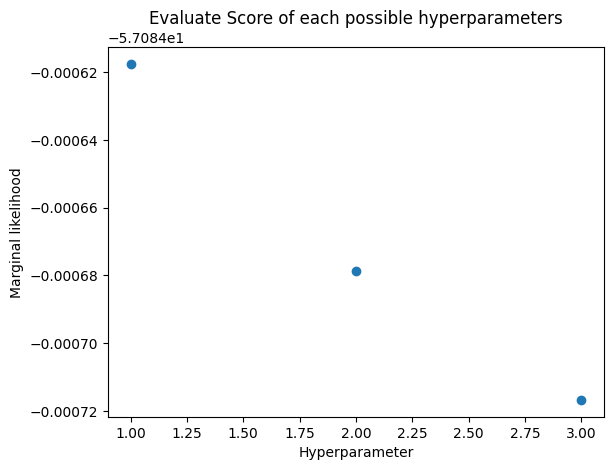

In [39]:
plt.scatter(X, Y)
plt.title('Evaluate Score of each possible hyperparameters')
plt.xlabel('Hyperparameter')
plt.ylabel('Marginal likelihood')
plt.show()